# 10. Transformer로 번역기 만들기

## 목차
- 1. 들어가며
- 2. 내부 모듈 구현하기
- 3. 모듈 조립하기
- 4. 모델 밖의 조력자들

## 1. 들어가며

- 트랜스포머는 현재까지도 각종 번역 부문에서 최고의 성능을 자랑하는 모델
- 트랜스포머로 번역기 만들어보기
- 트랜스포머 모델은 NLP 분야에서는 어느 곳에도 빠지지 않는 가장 중요한 모델 구조의 근간이 되기 때문에, 구현 실습을 통해 트랜스포머의 구조 꼼꼼히 파악해 보기

### 준비물
- 터미널을 열고 프로젝트를 위한 디렉토리 생성해 보기
- ```python
$ mkdir -p ~/aiffel/transformer
```
- 실습에서는 한국어가 포함된 말뭉치를 사용하므로, 한국어를 잘 시각화기 위한 준비가 필요
- 다만 'matplotlib' 라이브러리의 기본 폰트는 한국어를 지원하지 않음
- 올바른 Attention Map을 확인하기 위해 한국어를 지원하는 폰트로 변경해 주기
<br>

- 아직 컴퓨터에 글꼴이 설치되어 있지 않다면, 터미널에서 나눔 글꼴을 설치
- ```python
$ sudo apt -qq -y install fonts-nanum
```
- 아래 코드를 실행
- 앞으로 필요한 경우 한글을 실행해야 할 때 미리 한 번씩 실행해 주기

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname = fontpath, size=9)
plt.rc('font', family ='NanumBarunGothic') 
mpl.font_manager._rebuild()

## 2. 내부 모듈 구현하기

- 트랜스포머를 완성하는 데에 필요한 모듈들을 하나씩 만든 후, 조립하여 완성하는 방식으로 진행
<br>

- Tensor로 변환된 입력 데이터가 주어졌다고 가정하고 흐름을 생각해 보기
- 최초의 텍스트 입력 데이터는 \[batch_size x length\]의 형태를 가지고 있음
- 번역이 끝나고 난 최종 출력 데이터는 \[batch_size x length x vocab_size\]의 형태를 가지게 됨
- 번역 문제는 결국 매 스텝마다 'vocab_size' 만큼의 클래스 개수 중에 적당한 단어를 선택하는 작업을 'length'만큼 반복하는 것
- 모델 구성하는 과정에서 레이어를 통과할 때마다 텐서의 shape가 어떻게 바뀌는지 눈여겨보기

=====================================================================================================================================
- 1. 입력 데이터 -> \[batch_size x length\]
- 2. Source & Target Embedding -> \[batch_size x length x d_emb\]
- 3. **Positional Encoding** 강의 노드에서 구현. 2번의 결과에 더해지므로 shape 변화는 없음
- 4. **Multi-Head Attention** 아래와 같이 여러 개의 서브 모듈들이 존재
    - 1) **Split Heads** -> \[batch_size x length x heads x (d_emb / n_heads)\]
    - 2) **Masking for Masked Attention**
    - 3) **Scaled Dot Product Attention**
    - 4) **Combine Heads** -> \[batch_size x length x d_emb\]
- 5. Residual Connection
- 6. Layer Normalization
- 7. **Position-wise Feed-Forward Network** -> \[batch_size x length x d_ff\]
- 8. Output Linear Layer -> \[batch_size x length x vocab_size\]

=====================================================================================================================================

- **굵게** 표시된 모듈을 제외하면 나머지는 텐서플로우 내부에 이미 구현체가 포함되어 있어서 간단하게 사용할 수 있음
- **Positional Encoding**부터 시작
<br>

- 프로젝트에 사용될 라이브러리를 먼저 'import' 해주기

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

# Attention 시각화를 위해 필요!
import seaborn 

print(tf.__version__)

2.4.1


### Positional Encoding

![positional_encoding.png](./images/positional_encoding.png)
<br>

- 가장 먼저 구현할 Positional Encoding

In [3]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

### Multi-Head Attention
![multi_head_attention.png](./images/multi_head_attention.png)
- Multi-Head Attention은 여러 개의 서브 모듈을 결합하여 완성됨
- Embedding된 입력을 **Head 수로 본할**하는 'split_heads()', 분할된 입력으로부터 **Attention 값을 구하는** 'scaled_dot_product_attention()', 연산이 종료되고 분할된 **Head를 다시 하나로 결합**시켜주는 'combine_heads()'까지 'MultiHeadAttention' 클래스를 정의하여 모두 포함시켜줄 것
<br>

- 마스크의 형태를 결정하는 것이 모델 외부의 훈련 데이터이기 때문에 그를 생성하는 함수는 'MultiHeadAttention' 외부에 정의되는 것이 올바름
- 마스크를 생성하는 함수는 모델을 완성한 후에 구현
- 대신 생성된 마스크를 처리할 수 있도록 'scaled_dot_product_attention()'에는 아래 한 줄을 포함
- scaled_qk: Attention을 위한 Softmax 직전의 Scaled QK
- ```python
if mask is not None:
    scaled_qk += (mask * -1e9)
```

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        # Linear Layer
        self.W_q = tf.keras.layers.Dense(d_model) 
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)

        """
        Scaled QK 값 구하기
        """
        QK = tf.matmul(Q, K, transpose_b = True)

        if mask is not None: scaled_qk += (mask * -1e9) 

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        attentions = tf.nn.softmax(scaled_qk, axis = 1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm = [0, 2, 1, 3])
        
        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm = [0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))
        
        return combined_x
    

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(WQ_splits, WK_splits, WV_splits, mask)
        
        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

### Position-wise Feed-Forward Network
![position_wise_feed_forward_network.png](./images/position_wise_feed_forward_network.png)
<br>

- **Position-wise Feed-Forward Network**는 논문 설명에서도 아주 간략하게 적혀 있었음
- 구현도 아주 쉬운편

In [5]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

- 'd_ff'는 논문의 설명대로라도 2048일 거고, 'd_model'은 512
- \[batch x length x d_model\]의 입력을 받아 'w_1'이 2048 차원으로 매핑하고 활성함수 ReLU를 적용한 후, 다시 'w_2'를 통해 512차원으로 되돌리는 과정
- 이렇게 FNN 완성

## 3. 모듈 조립하기

- 내부에 포함될 모듈들을 모두 완성했음
- 이 모든 모듈들을 가지고 트랜스포머를 완성할 수 있는데, 정확하게는 트랜스포머의 **Encoder** 한 층과 **Decoder** 한 층을 각각 완성할 수 있음
<br>

- 이만큼의 코드를 5번 더 짜야 여섯 층짜리 논문 속 트랜스포머가 완성되는가?
- 보다 효율적인 방법으로 트랜스포머 완성할 예정
![표.png](./images/표.png)
- \<Attention Is All You Need\> 논문에 포함된 이 표는 트랜스포머가 얼마나 많은 실험을 통해서 탄생한 모델인지 보여줌
- 이런 실험이 가능하게 하려면 모델이 동적으로 완성될 수 있게끔 해야 함
- 즉, 레이어 수를 원하는 만큼 쌓아 실험을 자유자재로 할 수 있게 모델을 완성하자는 것
<br>

- 방법은 단순
- 마치 텐서플로우의 'Dense' 레이어를 사용하듯이 'EncoderLayer', 'DecoderLayer'를 쓸 수 있게 'tf.keras.layers.Layer' 클래스를 상속받아 레이어 클래스로 정의해 주면 됨
- 바로 직전의 'MultiHeadAttention'이 그렇게 정의된 레이어
- 이 방법을 사용하면 아래와 같은 용법으로 트래스포머 레이어 사용할 수 있음

```python
N = 10

# 10개의 Linear Layer를 한 방에!
linear_layers = [tf.keras.layers.Dense(30) for _ in range(N)]

# 10개의 Endoer Layer도 한 방에!
enc_layers = [TransformerEncoderLayer(30) for _ in range(N)]
```

### Encoder 레이어 구현하기
- 본격적으로 Layer 디자인해보기
- 먼저 'EncoderLayer' 구현 해보기
- 이를 참고해 'DecoderLayer' 구현 해보기

In [6]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


- Transformer의 구현은 정말 많은데, 그중에서 **Normalization Layer의 위치**에 대한 논의가 종종 나옴
- 실제 논문에서는 \[Input\] - \[Module\] - \[Residual\] - \[Norm\](Module = MHA, FFN)으로 표현되어 있지만 정작 Official 구현인 구굴의 Tensor2Tensor에서는 \[Input\] - \[Norm\]- \[Module\] - \[Residual\] 방식을 사용했음
<br>

- 레이어가 많아질수록 후자가 약간 더 좋은 성능을 보였기에 논문 대신 Official 구현을 따르길 권장
- 이번 프로젝트는 소규모라서 큰 차이가 나지 않으니 알아두기만 해도 괜찮음
<br>

- 트랜스포머의 Layer Normalization의 위치에 대한 논의를 다룬 [On Layer Normalizatoin in the Transformer Architecture](https://arxiv.org/pdf/2002.04745.pdf)이라는 제목의 논문이 2020년 초반에 발표되었음
- 이 논문에서는 모듈 앞에 Normalization Layer를 두는 pre-LN 방식이 왜 유리한지를 설명하고 있음

### Decoder 레이어 구현하기
- 위 'EncoderLayer' 클래스를 참고해여 'DecoderLyaer' 클래스를 완성하기
- (참고: Decoder에서는 2번의 Attention이 진행되니 반환되는 Attentioneh 2개)

In [7]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

- 'EncoderLayer'와 'DecoderLayer'를 모두 정의했으니 이를 조립하는 것은 어렵지 않음
- 이를 이용해 'Encoder'와 'Decoder' 클래스 정의하기

In [8]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

슝=3


In [9]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


### Transformer 완성하기
- 정의된 'Encoder'와 'Decoder'를 가지고 최종적으로 트랜스포머 완성하기
- 아래 조건을 만족하는 'Transformer 클래스 완성하기

======================================================================================================================================
- 1. '**shared**' 변수를 매개변수로 받아 '**True**'일 경우 **Decoder Embedding과 출력층 Linear의 Weight를 공유**할 수 있게 하기. Weight가 공유될 경우, Embedding 값에 **sqrt(d_model)**을 곱해줘야 함(참고: **tf.keras.layers.Layer.set_weights()**)
- 2. 정의한 '**positional_encoding**'의 변환값 형태는 '\[**Length x d_model**\]'인데, 이를 더해 줄 Embedding 값 형태가 **[Batch x Length x d_model]**'이라서 연산이 불가능함. 연산이 가능하도록 수정(참고:**tf.expand_dims(), np.newaxis**)

In [10]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

print("슝=3")

슝=3


## 4. 모델 밖의 조력자들

- **Masking**을 살펴볼 시간
- 트랜스포머의 **Learning Rate**는 일반적이지 않음
- 지금부터는 모델 외적인 부분 정의
- 이번 스텝에서는 데이터의 특성이나 학습 과정에 따라 달라지는 부분 다루게 됨
<br>

- 먼저 **Masking**
- 이전 노드에서 배운 'generate_causality_mask()'를 그대로 사용하면 되는데, 약간 추가할 내용이 있음
- 아래 구현을 먼저 보기

In [11]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


- generate_padding_mask()'는 Attention을 할 때에 \<PAD\> 토큰에도 Attention을 주는 것을 방지해 주는 역할
- 일전에 Sequence-to-Sequence 모델에서 Loss에 대한 Masking을 해줄 때도 위와 같은 방법으로 진행했음
- 한 배치의 데이터에서 \<PAD\> 토큰으로 이뤄진 부분을 모두 찾아내는 마스크를 생성함
- 아래 코드 통해 확인해보기

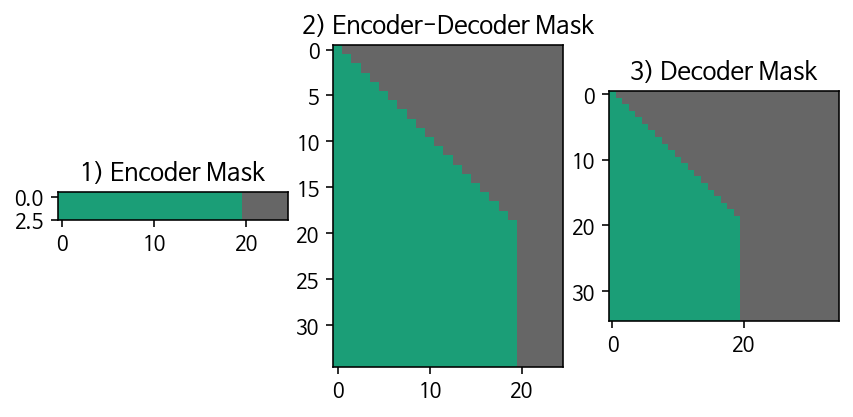

In [12]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

- 첫 번째 마스크는 각 배치 별로 **데이터의 꼬리 부분을 Masking**하는 형태임을 알 수 있음
- 낯선 부분은 두 번째와 세 번째의 Decoder가 연관된 마스크
- 이것이 바로 **Causality Mask와 Padding Mask를 결합한 형태**
- 자기 회귀적인 특성을 살리기 위해 Masked Multi-Head Attention에서 **인과 관계 마스킹**을 했음
- 인과 관계를 가리는 것도 중요하지만 Decoder 역시 \<PAD\> 토큰은 피해 가야 하기 때문에 이런 형태의 마스크가 사용됨
<br>

- 또, 트랜스포머는 고정된 Learning Rate를 사용하지 않았음
- 논문의 해당 부분을 Optimize까지 포함하여 다시 한번 살펴보기
- 이전 노드에서 Learning Rate를 'numpy'로 간단히 구현을 했었음
- 이번에 **Tensorflow상에서 잘 구동될 수 있도록** 'LearningRateSchedule' 클래스를 상속받아 구현

In [13]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

print("슝=3")

슝=3


- 트랜스포머가 제안한 수식이 아니더라도 가변적인 Learning Rate를 사용하려면 위와 같이 구현을 하면 됨
- Optimizer와 Scheduler를 연결하는 과정도 아주 간단함
- Optimizer는 논문에 정의된 대로 Adam Optimizer를 사용하며 세부 파라미터도 동일하게 맞춰 줌